# 1. Dependências e Constantes

In [1]:
# Import das Libs
import os

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import nltk
import gensim
import seaborn as sns


nltk.download('words')

pd.set_option('display.max_rows', 150)
from nltk.corpus import words
from textblob import TextBlob
from googletrans import Translator
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from lyrics_analysis.clean_data import tokenize_lemmatize, word_count,  normalize, detect_lang_lyrics
from lyrics_analysis.analyse_data import n_most_common

[nltk_data] Downloading package words to
[nltk_data]     /Users/bruno.santos/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
import pandas as pd
import numpy as np
data = np.random.randn(5000, 1)
df = pd.DataFrame(data, columns=["value"])

In [3]:
# Constantes
DATA_RAW_NAME = 'lyrics.csv'
DATA_STOPWORDS_NAME = 'stopwords.txt'
DATA_PROCESSED_NAME = 'lyrics_processed.csv'
DATA_RAW_PATH =  os.path.abspath(os.path.join('..', 'data','raw', DATA_RAW_NAME))
DATA_STOPWORDS_PATH = os.path.abspath(os.path.join('..', 'data','raw', DATA_STOPWORDS_NAME))
DATA_PROCESSED_PATH = os.path.abspath(os.path.join('..', 'data','processed', DATA_PROCESSED_NAME ))

In [4]:
# Dados
lyrics_raw = pd.read_csv(DATA_RAW_PATH)
stopwords = pd.read_csv(DATA_STOPWORDS_PATH)
stopwords = stopwords['stopwords'].tolist()
stopwords = list(map(lambda x: x.replace(' ', ''),stopwords))
stopwords += words.words()

# 2. Limpeza Inicial

In [4]:
lyrics_raw

,group,lyrics_title,lyrics_text
0,Legião Urbana,1° de Julho,Eu vejo que aprendi O quanto te ensinei E é n...
1,Legião Urbana,1965 (Duas Tribos),Vou passar Quero ver Volta aqui Vem você Como...
2,Legião Urbana,1977,Todos os dias quando acordo de manhã Não tenh...
3,Legião Urbana,A Canção Do Senhor Da Guerra,Existe alguém esperando por você Que vai comp...
4,Legião Urbana,A Cruz e a Espada,"Havia um tempo, em que eu vivia Um sentimento..."
...,...,...,...
3424,Los Hermanos,Um Par,"Mesmo quando ele consegue o que ele quis, Qua..."
3425,Los Hermanos,Uma Brasileira,"Rodas em sol, Trovas em dó Uma brasileira, ô ..."
3426,Los Hermanos,Vai Embora,Não sei mais o que fazer da minha vida sem vo...
3427,Los Hermanos,Vambora,Entre por essa porta agora E diga que me ador...


In [5]:
# Filtrando 
lyrics_raw_lang = detect_lang_lyrics(lyrics_raw, 'lyrics_text')


100%|██████████| 3429/3429 [38:37<00:00,  1.48it/s] 


In [92]:
"Bruno Carlos".split()

['Bruno', 'Carlos']

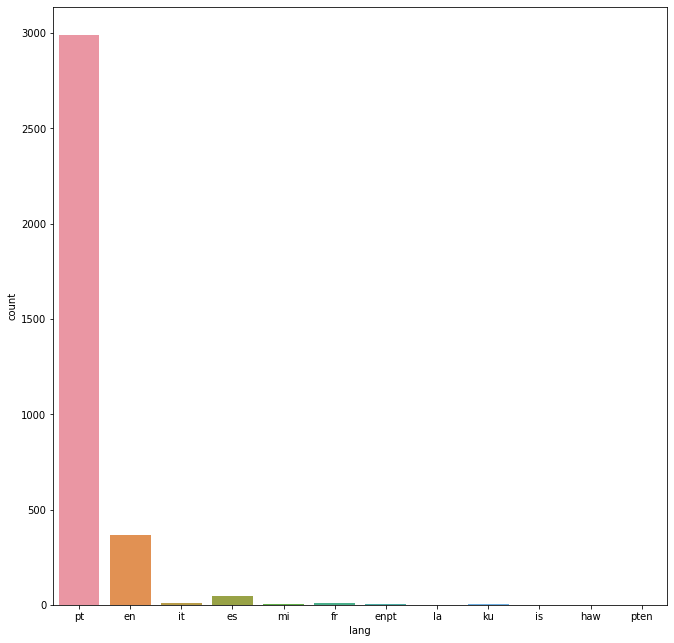

In [10]:
# QUe idiomas temos?
fig, ax = plt.subplots(figsize=(11, 11))

ax = sns.countplot(x="lang", data=lyrics_raw_lang)
plt.savefig(os.path.abspath(os.path.join(os.getcwd(),'..', 'img','lang_freq.jpg')))

In [11]:
#Lower casing
lyrics_lang_normalized = normalize(lyrics_raw_lang, 'lyrics_text', 'lyrics_text_normalized')

In [12]:
#Quantos instrumentais temos?
(lyrics_lang_normalized['lyrics_text_normalized'].str.contains('instrumental')).sum()

27

In [13]:
# Removendo os instrumentais
lyrics_lang_normalized['is_instrumental'] = lyrics_lang_normalized['lyrics_text_normalized'].str.contains('instrumental')
lyrics_lang_normalized = lyrics_lang_normalized[lyrics_lang_normalized['is_instrumental'] == False]


In [14]:
# Replace para substituir gíria usada 
lyrics_lang_normalized['lyrics_text_normalized'] = lyrics_lang_normalized['lyrics_text_normalized'].apply(lambda x: x.replace('pra', 'para'))

In [15]:
# Filtrando para remover os erros na identificação da linguagem e as músicas que são instrumentais
lyrics_lang_normalized = lyrics_lang_normalized.loc[(lyrics_lang_normalized['is_instrumental']==False) | (lyrics_lang_normalized['lang']=='Error'),:]

In [16]:
# Traduzindo as músicas de outro idioma para o português
lyrics_translated_pt= []
lyrics_translated_en = []
trl = Translator()
for lang, lyrics_text_normalized in tqdm(zip(lyrics_lang_normalized['lang'],lyrics_lang_normalized['lyrics_text_normalized'])):
    sent = lyrics_text_normalized
    try:
        lyrics_translated_pt.append(trl.translate(sent, src = lang, dest='pt').text)
    except:
        lyrics_translated_pt.append('Error')
        
    try:
        lyrics_translated_en.append(trl.translate(sent, src = lang, dest = 'en').text)
    except:
        lyrics_translated_en.append('Error')


3402it [43:53,  1.29it/s]


In [17]:
lyrics_lang_normalized['lyrics_text_normalized_en'] = lyrics_translated_en
lyrics_lang_normalized['lyrics_text_normalized_pt'] = lyrics_translated_pt

In [19]:
lyrics_lang_normalized_tokenized = tokenize_lemmatize(lyrics_lang_normalized, column = 'lyrics_text_normalized_pt', 
                                       new_name='lyrics_text_normalized_tokenized_pt', remove_stopwords=True, stopwords=stopwords)

In [20]:
lyrics_lang_normalized_tokenized.to_csv(DATA_PROCESSED_PATH, index = False)

# 3.Análise Exploratória

## 3.2 Word Cloud

In [5]:
lyrics_lang_normalized_tokenized = pd.read_csv(DATA_PROCESSED_PATH)

In [6]:
lyrics_lang_normalized_tokenized = lyrics_lang_normalized_tokenized[(lyrics_lang_normalized_tokenized['lyrics_text_normalized_pt'] != 'Error') 
                                                          & (lyrics_lang_normalized_tokenized['lyrics_text_normalized_en'] != 'Error')]

In [7]:
lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt'] = lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt'].str.split()

In [8]:
lyrics_lang_normalized_tokenized = lyrics_lang_normalized_tokenized[lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt'].apply(lambda x: type(x)==list)]

In [9]:
top10terms = n_most_common(lyrics_lang_normalized_tokenized, 'lyrics_text_normalized_tokenized_pt', n=10)

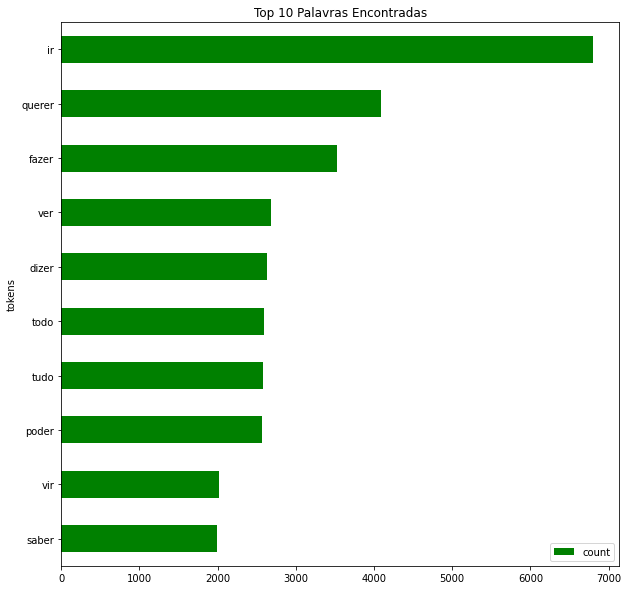

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot horizontal bar graph
top10terms.sort_values(by='count').plot.barh(x='tokens',
                      y='count',
                      ax=ax,
                      color="green")

ax.set_title("Top 10 Palavras Encontradas")

plt.savefig(os.path.abspath(os.path.join('..', 'img','top_10_tokens.jpg')))
plt.show()



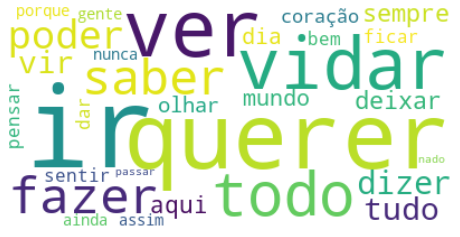

In [20]:
import itertools
all_tokens = lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt'].tolist()
all_tokens = list(itertools.chain(*all_tokens))
wordcloud = WordCloud(max_font_size=100, max_words=30, background_color="white").generate(' '.join(all_tokens))
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(os.path.abspath(os.path.join('..', 'img','word_cloud_50.jpg')))
plt.show()

## 3.3 Tokens per Artists

In [22]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bruno.santos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [23]:
sid = SentimentIntensityAnalyzer()

In [24]:
sid.polarity_scores('h')

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

In [25]:
lyrics_lang_normalized_tokenized['count_tokens'] = lyrics_lang_normalized_tokenized['lyrics_text_normalized_tokenized_pt'].apply(lambda x: len(x))

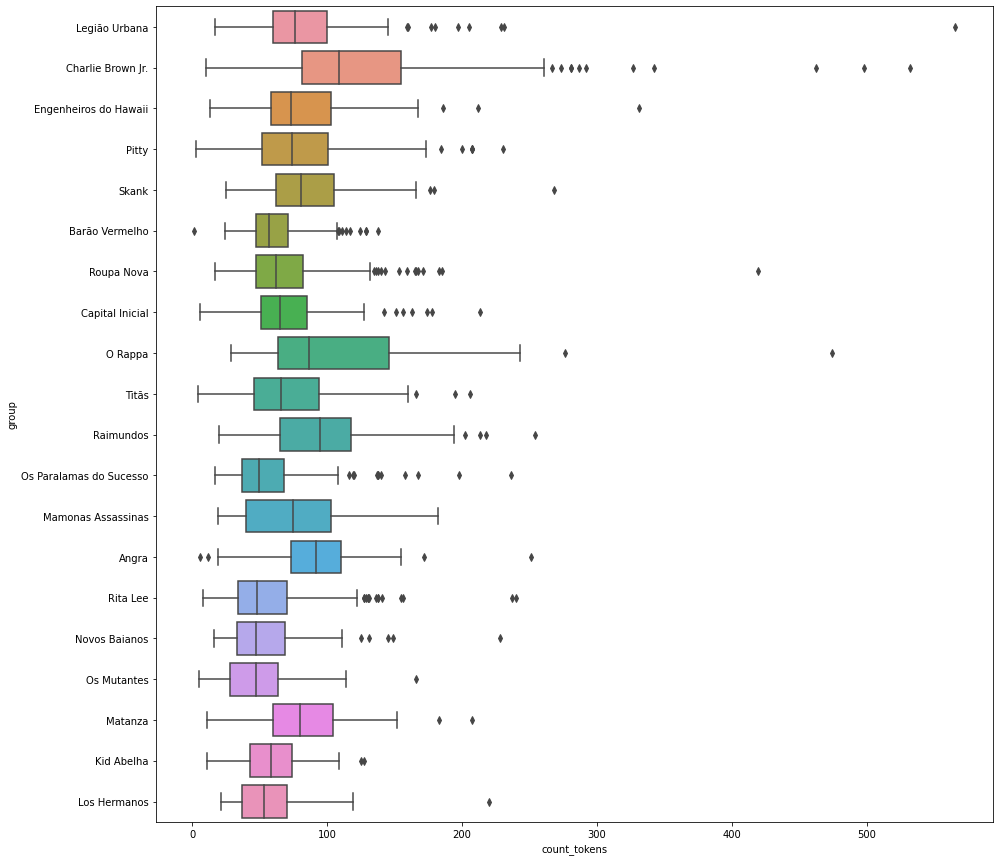

In [26]:
plt.figure(figsize=(15,15))
ax = sns.boxplot(x="count_tokens", y="group", data=lyrics_lang_normalized_tokenized, orient = 'h')
plt.savefig(os.path.abspath(os.path.join(os.getcwd(),'..', 'img','tokens_per_artist.jpg')))

## 3.4 Unique Tokens Per Artists


In [27]:
list_unique_group = lyrics_lang_normalized_tokenized['group'].unique()
group_unique_tokens = {}
for group in list_unique_group:
    all_tokens = lyrics_lang_normalized_tokenized.loc[lyrics_lang_normalized_tokenized['group']==group,'lyrics_text_normalized_tokenized_pt'].tolist()
    all_tokens = list(itertools.chain(*all_tokens))
    group_unique_tokens[group] = len(set(all_tokens))
    

In [28]:
unique_tokens = pd.DataFrame.from_dict(group_unique_tokens, orient = 'index').reset_index()

In [29]:
unique_tokens.columns = ['group', 'unique_tokens']

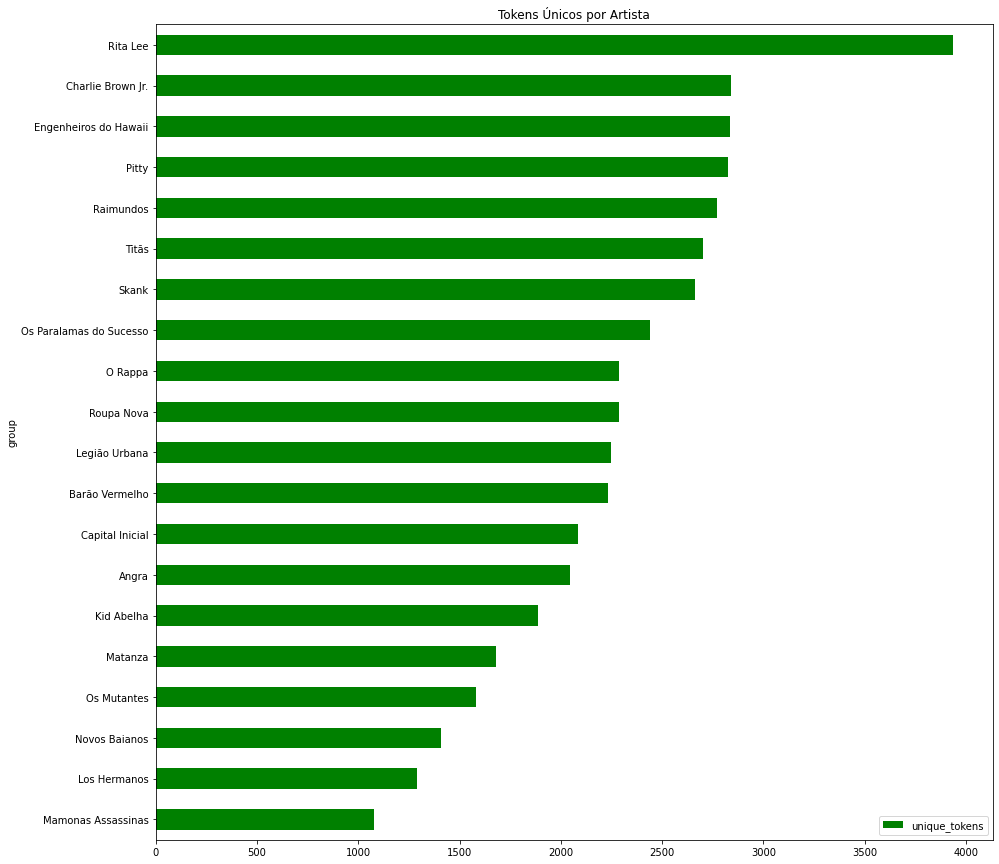

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot horizontal bar graph
unique_tokens.sort_values(by= 'unique_tokens').plot.barh(x='group',
                      y='unique_tokens',
                      ax=ax,
                      color="green")

ax.set_title("Tokens Únicos por Artista")

plt.savefig(os.path.abspath(os.path.join('..', 'img','unique_tokens_per_artist.jpg')))
plt.show()

## 3.4 Número de Músicas por Artista

In [31]:
group_count_lyrics = pd.DataFrame(lyrics_lang_normalized_tokenized['group'].value_counts().reset_index())
group_count_lyrics.columns = ['group', 'n_lyrics']

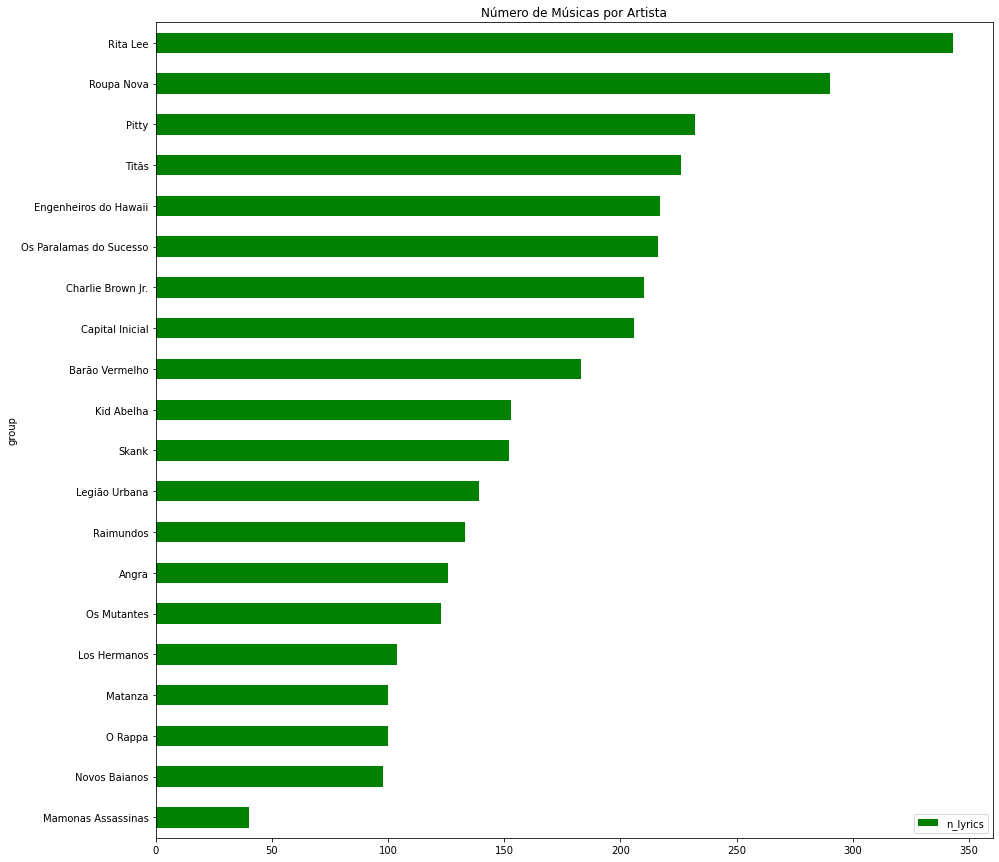

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot horizontal bar graph
group_count_lyrics.sort_values(by= 'n_lyrics').plot.barh(x='group',
                      y='n_lyrics',
                      ax=ax,
                      color="green")

ax.set_title("Número de Músicas por Artista")

plt.savefig(os.path.abspath(os.path.join('..', 'img','lyrics_per_artist.jpg')))
plt.show()



In [22]:
unique_tokens_count_lyrics = group_count_lyrics.merge(unique_tokens, on ='group', how = 'inner')

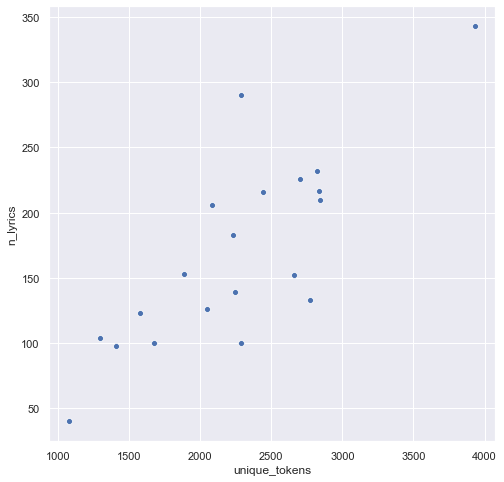

In [23]:
sns.set()
fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.scatterplot(x="unique_tokens", y="n_lyrics", data=unique_tokens_count_lyrics)
plt.savefig(os.path.abspath(os.path.join('..', 'img','unique_tokens_vs_n_lyrics.jpg')))

## 3.5 Sentimento

In [24]:
sentiment_lyrics = []
for lyrics_text in tqdm(lyrics_lang_normalized_tokenized['lyrics_text_normalized_en']):
    try:
        lyrics_text_blob = TextBlob(lyrics_text)
        sentiment_lyrics.append(lyrics_text_blob.sentiment[0])
    except:
        sentiment_lyrics.append(-999)
lyrics_lang_normalized_tokenized['lyrics_sentiment'] = sentiment_lyrics
lyrics_lang_normalized_tokenized = lyrics_lang_normalized_tokenized[lyrics_lang_normalized_tokenized['lyrics_sentiment']!=-999]

100%|██████████| 3391/3391 [00:02<00:00, 1199.51it/s]


In [25]:
sentiment_lyrics_pos = []
sentiment_lyrics_neu = []
sentiment_lyrics_neg = []

for lyrics_text in tqdm(lyrics_lang_normalized_tokenized['lyrics_text_normalized_en']):
    try:
        lyrics_text_sentiment = sid.polarity_scores(lyrics_text)
        sentiment_lyrics_pos.append(lyrics_text_sentiment['pos'])
        sentiment_lyrics_neg.append(lyrics_text_sentiment['neg'])
        sentiment_lyrics_neu.append(lyrics_text_sentiment['neu'])

    except:
        sentiment_lyrics_pos.append(-999)
        sentiment_lyrics_neg.append(-999)
        sentiment_lyrics_neu.append(-999)
lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_pos'] = sentiment_lyrics_pos
lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_neg'] = sentiment_lyrics_neg
lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_neu'] = sentiment_lyrics_neu

lyrics_lang_normalized_tokenized = lyrics_lang_normalized_tokenized[(lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_pos']!=-999) & (lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_neg']!=-999) & (lyrics_lang_normalized_tokenized['lyrics_sentiment_vader_neu']!=-999)]

100%|██████████| 3391/3391 [00:03<00:00, 863.93it/s] 


In [26]:
sentiment_group_vader = lyrics_lang_normalized_tokenized.groupby(['group']).agg({'lyrics_sentiment_vader_pos':'mean', 'lyrics_sentiment_vader_neg':'mean','lyrics_sentiment_vader_neu':'mean'}).sort_values(by='lyrics_sentiment_vader_pos', ascending = False)

In [27]:
sentiment_group_vader

,lyrics_sentiment_vader_pos,lyrics_sentiment_vader_neg,lyrics_sentiment_vader_neu
group,,,
Roupa Nova,0.188152,0.072141,0.739714
Charlie Brown Jr.,0.160638,0.096633,0.742771
Rita Lee,0.157516,0.097274,0.745254
Barão Vermelho,0.156689,0.105383,0.737967
Los Hermanos,0.155394,0.088798,0.755856
Legião Urbana,0.144727,0.118187,0.737058
Kid Abelha,0.144686,0.091150,0.764137
Os Mutantes,0.143577,0.074350,0.782122
Os Paralamas do Sucesso,0.132296,0.092296,0.775463


In [28]:
sentiment_group = lyrics_lang_normalized_tokenized.groupby(['group']).agg({'lyrics_sentiment':'mean'}).sort_values(by='lyrics_sentiment', ascending = False)

In [29]:
sentiment_group

,lyrics_sentiment
group,
Roupa Nova,0.208037
Los Hermanos,0.159326
Charlie Brown Jr.,0.145556
Novos Baianos,0.140206
Skank,0.133172
Kid Abelha,0.131304
Rita Lee,0.120616
Os Paralamas do Sucesso,0.116583
Barão Vermelho,0.115110


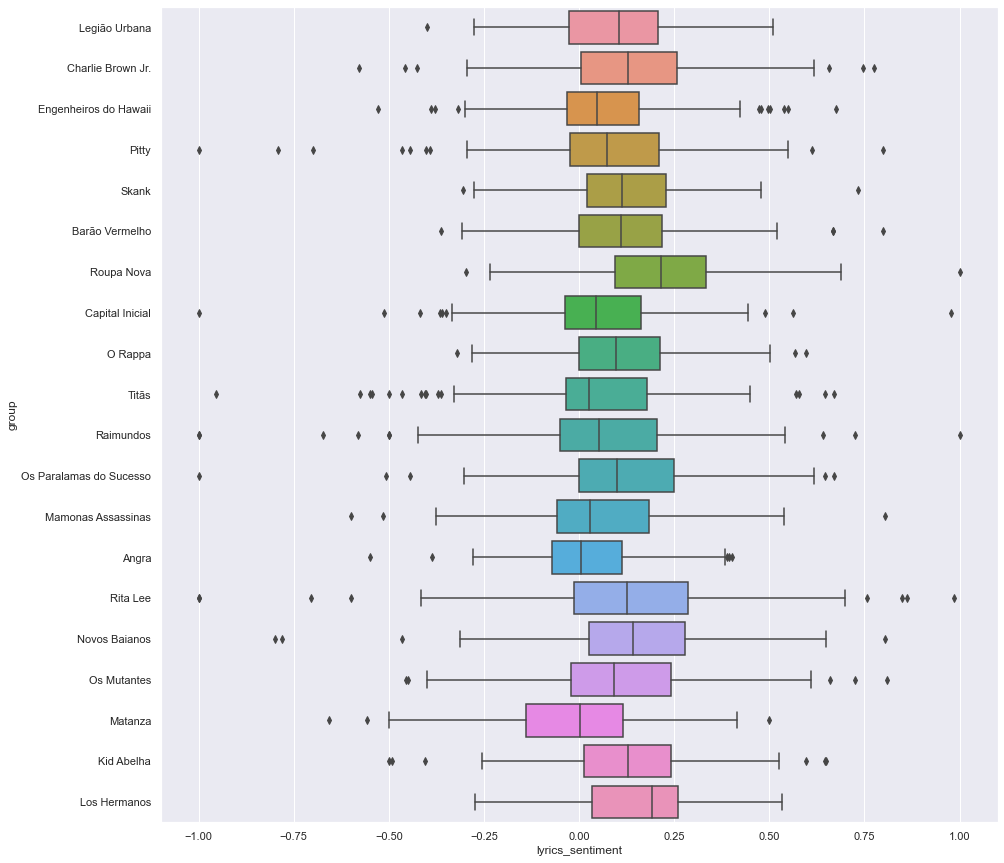

In [33]:
plt.figure(figsize=(15,15))
ax = sns.boxplot(x="lyrics_sentiment", y="group", data=lyrics_lang_normalized_tokenized, orient = 'h')
plt.savefig(os.path.abspath(os.path.join('..', 'img','sentiment_artists.jpg')))

In [35]:
lyrics_lang_normalized_tokenized.nlargest(columns = 'lyrics_sentiment_vader_pos',n= 10)

,group,lyrics_title,lyrics_text,lang,lyrics_text_normalized,is_instrumental,lyrics_text_normalized_en,lyrics_text_normalized_pt,lyrics_text_normalized_tokenized_pt,count_tokens,lyrics_sentiment,lyrics_sentiment_vader_pos,lyrics_sentiment_vader_neg,lyrics_sentiment_vader_neu
2780,Rita Lee,Tapupukitipa,Yeah! Yeah! Yeah! Tapu pukitipa! Yeah! Yeah! ...,en,yeah! yeah! yeah! tapu pukitipa! yeah! yeah! ...,False,yeah! yeah! yeah! tapu pukitipa! yeah! yeah! y...,sim! sim! sim! tapu pukitipa! sim! sim! sim! t...,"[sim, sim, sim, pukitipa, sim, sim, sim, pukit...",9,0.000000,0.742,0.000,0.258
3027,Os Mutantes,Tapupukitpa,Yeah! Yeah! Yeah! Tapu pukitipa! Yeah! Yeah! ...,en,yeah! yeah! yeah! tapu pukitipa! yeah! yeah! ...,False,yeah! yeah! yeah! tapu pukitipa! yeah! yeah! y...,sim! sim! sim! tapu pukitipa! sim! sim! sim! t...,"[sim, sim, sim, pukitipa, sim, sim, sim, pukit...",9,0.000000,0.742,0.000,0.258
30,Legião Urbana,Conexão Amazônica,"Estou cansado de ouvir falar Em Freud, Jung, ...",pt,"estou cansado de ouvir falar em freud, jung, ...",False,"I'm tired of hearing about freud, jung, engels...","estou cansado de ouvir falar em freud, jung, e...","[cansar, ouvir, falar, freud, jung, engels, ma...",63,-0.035417,0.673,0.041,0.286
2612,Rita Lee,Eu Vou Me Salvar,"Eu vou me salvar, eu vou me salvar Eu vou me ...",pt,"eu vou me salvar, eu vou me salvar eu vou me ...",False,"I will save myself, I will save myself I will ...","eu vou me salvar, eu vou me salvar eu vou me s...","[ir, salvar, ir, salvar, ir, salvar, ir, salva...",36,0.000000,0.557,0.000,0.443
2016,Raimundos,I Wanna Be Well,"Yeah, I wanna be well I wanna be well I wanna...",en,"yeah, i wanna be well i wanna be well i wanna...",False,"yeah, i wanna be well i wanna be well i wanna ...","sim, eu quero estar bem eu quero estar bem eu ...","[sim, querer, estar, bem, querer, estar, bem, ...",98,-0.500000,0.502,0.073,0.426
2759,Rita Lee,Reza,Deus me proteja da sua inveja Deus me defenda...,pt,deus me proteja da sua inveja deus me defenda...,False,god protect me from your envy god defend me fr...,deus me proteja da sua inveja deus me defenda ...,"[deus, proteger, invejar, deus, defender, macu...",71,0.085714,0.489,0.081,0.430
2170,Os Paralamas do Sucesso,I Feel Good (I Got You/Sossego),I feel good I knew that I would now I feel go...,pt,i feel good i knew that i would now i feel go...,False,i feel good i knew that i would now i feel goo...,i feel good i knew that i would now i feel go...,"[-vitória, régio, bolar, papar, empregar, uuu,...",20,0.668750,0.485,0.000,0.515
2773,Rita Lee,Sou Fiel,Sou Fiel Sou fiel de coração Sou fiel a uma...,pt,sou fiel sou fiel de coração sou fiel a uma...,False,I am faithful I am faithful at heart I am fait...,sou fiel sou fiel de coração sou fiel a uma ...,"[fiel, fiel, coração, fiel, paixão, fiel, graç...",70,0.233333,0.483,0.000,0.517
2970,Os Mutantes,Eu Só Penso Em Te Ajudar,Estão dizendo que é pra competir Mas eu só p...,pt,estão dizendo que é para competir mas eu só ...,False,they are saying it is to compete but I only th...,estão dizendo que é para competir mas eu só p...,"[dizer, competir, pensar, ajudar, querer, vida...",34,0.482143,0.471,0.020,0.509
2530,Rita Lee,Benvinda,Benvinda Eu estou em paz Você demorou Por ond...,pt,benvinda eu estou em paz você demorou por ond...,False,welcome i'm at peace did you take where you be...,benvinda eu estou em paz você demorou por onde...,"[benvinda, paz, demorar, onde, andar, ficar, c...",20,0.756250,0.462,0.091,0.447


In [54]:
print(lyrics_lang_normalized_tokenized.loc[lyrics_lang_normalized_tokenized['lyrics_title']=='Cruela Cruel', ['lyrics_text_normalized_pt']].values)

[["sou um ninho no estranho mundo perigoso, insano nexo, yogas e roquebrou nunca a vida se mostrou assim tão cruela cruel, cruela cruel sou madre de calcutá tentando salvar o planeta às vezes destruo o universo com o garbo de uma greta viúva negra de maquiavel maquiavel, maquiavel... cruela cruel, cruela cruela... it's heaven in hell os inimigos ocultos se mostram incompetentes tédio, anfa e paranóia sempre achei no amor a glória mais cruela cruel cruela cruel terra telepática lunática, anos-luz sem ídolos, heróis, profetas, gurus só a sombra de uma bomba, bruxa má medusa jezebel jezebel, jezebel... cruela cruel, cruela cruela cruela cruel, cruela cruela cruela cruel it's heaven in hell!"]]


In [37]:
lyrics_lang_normalized_tokenized.nlargest(columns = 'lyrics_sentiment_vader_neg',n= 10)

,group,lyrics_title,lyrics_text,lang,lyrics_text_normalized,is_instrumental,lyrics_text_normalized_en,lyrics_text_normalized_pt,lyrics_text_normalized_tokenized_pt,count_tokens,lyrics_sentiment,lyrics_sentiment_vader_pos,lyrics_sentiment_vader_neg,lyrics_sentiment_vader_neu
2567,Rita Lee,Cruela Cruel,"Sou um ninho no estranho Mundo perigoso, insa...",pt,"sou um ninho no estranho mundo perigoso, insa...",False,"I am a nest in the strange dangerous world, in...","sou um ninho no estranho mundo perigoso, insan...","[ninhar, estranhar, mundo, perigoso, insano, n...",69,-0.704301,0.062,0.634,0.304
1934,Titãs,Tô Cansado,Tô cansado Tô cansado de tudo Tô cansado do m...,pt,tô cansado tô cansado de tudo tô cansado do m...,False,I'm tired I'm tired of everything I'm tired of...,tô cansado tô cansado de tudo tô cansado do me...,"[tô, cansar, tô, cansar, tudo, tô, cansar, cab...",77,-0.370759,0.000,0.598,0.402
2013,Raimundos,I Don't Care,I don't care I don't care I don't care about ...,en,i don't care i don't care i don't care about ...,False,i don't care i don't care i don't care about t...,"Eu não ligo, eu não ligo, eu não ligo para est...","[Eu, ligar, ligar, ligar, mundo, ligar, garoto...",30,0.000000,0.000,0.586,0.414
1890,Titãs,Planeta Morto,Era um planeta fértil Tinha as maiores frutas...,pt,era um planeta fértil tinha as maiores frutas...,False,it was a fertile planet had the biggest fruits...,era um planeta fértil tinha as maiores frutas ...,"[fértil, maior, frutar, cheio, homem, forte, p...",71,-0.157619,0.052,0.501,0.447
1846,Titãs,Medo,Precisa perder o medo do sexo Precisa perder...,pt,precisa perder o medo do sexo precisa perder...,False,you need to lose your fear of sex you need to ...,precisa perder o medo do sexo precisa perder ...,"[preciso, perder, medo, sexo, preciso, perder,...",80,0.000000,0.000,0.497,0.503
3048,Matanza,Alabama Death Tenebris,Alabama grindcore Holy noise - death tenebris...,en,alabama grindcore holy noise - death tenebris...,False,alabama grindcore holy noise - death tenebris ...,Alabama Grindcore Santo barulho - morte Tenebr...,"[Grindcore, barulhar, morte, Tenebris, conspir...",29,-0.435732,0.000,0.478,0.522
149,Charlie Brown Jr.,"Ai, Ai, Ai (Estúdio Coca-cola)",Tchunanananã! Ná Nã Nã! Ná Nã Nã! Ná Nã Nã! T...,pt,tchunanananã! ná nã nã! ná nã nã! ná nã nã! t...,False,tchunanananã! no no no! no no no! no no no! tc...,tchunanananã! ná nã nã! ná nã nã! ná nã nã! tc...,"[tchunanananã, ná, nã, nã, ná, nã, nã, ná, nã,...",210,0.410623,0.088,0.459,0.453
2012,Raimundos,Hooligans,hooligans are made to destroy hooligans are b...,en,hooligans are made to destroy hooligans are b...,False,hooligans are made to destroy hooligans are bo...,hooligans são feitos para destruir hooligans n...,"[hooligan, feito, destruir, hooligan, nascer, ...",36,-0.050000,0.112,0.455,0.433
527,Engenheiros do Hawaii,Revelação,Um dia vestido De saudade viva Faz ressucitar...,pt,um dia vestido de saudade viva faz ressucitar...,False,"one day dressed with homesickness, he resurrec...",um dia vestido de saudade viva faz ressucitar ...,"[dia, vestir, saudade, fazer, ressucitar, casa...",37,-0.228571,0.072,0.447,0.481
2506,Rita Lee,As Loucas,Eles amam as loucas Mas se casam com outras E...,pt,eles amam as loucas mas se casam com outras e...,False,they love the crazy but they marry others they...,eles amam as loucas mas se casam com outras el...,"[amar, louco, casar, outro, amar, louco, casar...",78,-0.310326,0.239,0.447,0.314


In [38]:
df_topics = lyrics_lang_normalized_tokenized[lyrics_lang_normalized_tokenized['lang']=='pt']

In [39]:
all_lyrics_list = list(df_topics['lyrics_text_normalized_tokenized_pt'])

## 3.6 Tópicos

In [40]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(all_lyrics_list, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[all_lyrics_list], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [41]:

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [42]:
lyrics_bigrams = make_bigrams(all_lyrics_list)


In [43]:
id2word = corpora.Dictionary(lyrics_bigrams)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in lyrics_bigrams]

In [50]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [51]:

# Visualize the topics

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.324941 -0.096480       1        1  70.616554
3     -0.010089  0.278350       2        1  14.086035
1      0.123710 -0.112898       3        1  10.493287
2      0.211320 -0.068973       4        1   4.804123, topic_info=         Term         Freq        Total Category  logprob  loglift
23         ir  6433.000000  6433.000000  Default  30.0000  30.0000
127        lá   862.000000   862.000000  Default  29.0000  29.0000
43     querer  3430.000000  3430.000000  Default  28.0000  28.0000
152       dar  1274.000000  1274.000000  Default  27.0000  27.0000
491        tá   565.000000   565.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
452       rei    50.780186   155.882721   Topic4  -5.3269   1.9141
1898   veneno    27.473755    40.333424   Topic4  -5.9412   2.6517
164    gostar    41.551929   533.861816   Topic4  -5.5275   0.4825
1547  namorar    27.639240   145.050552   Topic4  -5.9352   1.3778
1057    rapaz    24.702541    85.037483   Topic4  -6.0475   1.7995

[220 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
336        3  0.988732     's
439        1  0.291369    ali
439        2  0.706009    ali
190        1  0.751957  andar
190        2  0.246485  andar
...      ...       ...    ...
5860       3  0.043968    ê_ê
5860       4  0.967302    ê_ê
8225       4  0.980430  êh_êh
11854      3  0.979670     ói
2159       3  0.996590      ô

[253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [52]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.042*"ir" + 0.022*"querer" + 0.019*"fazer" + 0.016*"ver" + 0.015*"dizer" + '
  '0.014*"tudo" + 0.013*"poder" + 0.013*"saber" + 0.012*"todo" + 0.011*"vir"'),
 (1,
  '0.017*"tá" + 0.010*"dar" + 0.007*"ô" + 0.006*"caro" + 0.006*"santo" + '
  '0.005*"homem" + 0.004*"entrar" + 0.004*"todo" + 0.004*"joão" + '
  '0.004*"morrer"'),
 (2,
  '0.029*"lá" + 0.014*"senhor" + 0.014*"rodar" + 0.014*"mulher" + 0.008*"uh" + '
  '0.006*"bocar" + 0.006*"josé" + 0.006*"somente" + 0.006*"giro" + '
  '0.005*"doido"'),
 (3,
  '0.013*"céu" + 0.009*"terra" + 0.008*"água" + 0.008*"lua" + 0.007*"menino" + '
  '0.007*"pé" + 0.007*"luzir" + 0.007*"medo" + 0.007*"ruir" + 0.006*"vir"')]
